In [15]:
!pip install nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


import os

# Création d'un répertoire local au cas où les chemins par défaut posent problème
nltk_data_dir = os.path.join(os.getcwd(), "nltk_data")
os.makedirs(nltk_data_dir, exist_ok=True)

# Ajout manuel au chemin
nltk.data.path.append(nltk_data_dir)

# Téléchargements des ressources nécessaires dans le bon répertoire
nltk.download("punkt", download_dir=nltk_data_dir)
nltk.download("stopwords", download_dir=nltk_data_dir)
nltk.download("wordnet", download_dir=nltk_data_dir)




[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


[nltk_data] Downloading package punkt to /Users/salhinina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/salhinina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/salhinina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/salhinina/Desktop/Mach
[nltk_data]     ine_learning/Projet/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /Users/salhinina/Desktop/
[nltk_data]     Machine_learning/Projet/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/salhinina/Desktop/Ma
[nltk_data]     chine_learning/Projet/nltk_data...


True

In [50]:
df=pd.read_csv('scitweets_export.tsv', sep='\t')
display (df.head())
print("Nombre total de lignes :", len(df))

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


Nombre total de lignes : 1140


In [30]:
#-------------------------------
#----Analyse du jeu de données – partie scientifique uniquement--------
#------------------------------

Nombre de lignes scientifiques : 375

Occurrences parmi les scientifiques :
- CLAIM uniquement : 124
- REF uniquement : 0
- CLAIM + REF : 124
- CONTEXT uniquement : 33


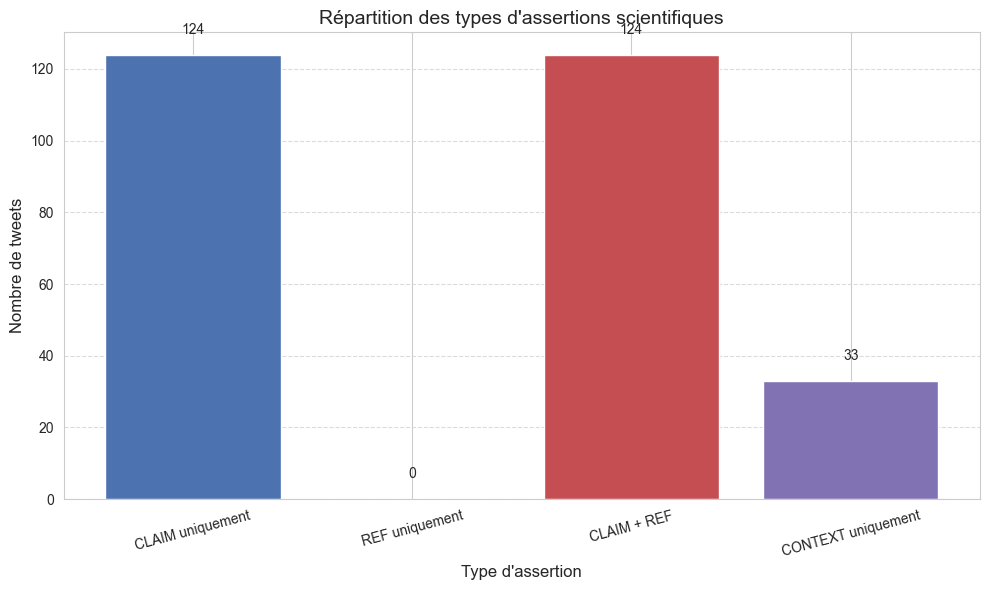

In [52]:
# 3. Filtrer les lignes scientifiques
df_sci = df[df["science_related"] == 1]
print("Nombre de lignes scientifiques :", len(df_sci))

# 4. Détailler les sous-catégories parmi les scientifiques

# a. CLAIM uniquement
claim_only = df_sci[(df_sci["scientific_claim"] == 1.0) &
                    (df_sci["scientific_reference"] == 0.0) &
                    (df_sci["scientific_context"] == 0.0)]

# b. REF uniquement
ref_only = df_sci[(df_sci["scientific_reference"] == 1.0) &
                  (df_sci["scientific_claim"] == 0.0) &
                  (df_sci["scientific_context"] == 0.0)]

# c. CLAIM + REF
claim_ref = df_sci[(df_sci["scientific_claim"] == 1.0) &
                   (df_sci["scientific_reference"] == 1.0)]

# d. CONTEXT uniquement
context_only = df_sci[(df_sci["scientific_context"] == 1.0) &
                      (df_sci["scientific_claim"] == 0.0) &
                      (df_sci["scientific_reference"] == 0.0)]

# 5. Afficher les résultats
print("\nOccurrences parmi les scientifiques :")
print("- CLAIM uniquement :", len(claim_only))
print("- REF uniquement :", len(ref_only))
print("- CLAIM + REF :", len(claim_ref))
print("- CONTEXT uniquement :", len(context_only))

# 4. Création du dictionnaire de comptage
counts = {
    "CLAIM uniquement": len(claim_only),
    "REF uniquement": len(ref_only),
    "CLAIM + REF": len(claim_ref),
    "CONTEXT uniquement": len(context_only)
}

# 5. Création du DataFrame pour affichage
df_counts = pd.DataFrame(list(counts.items()), columns=["Catégorie", "Nombre"])

# 6. Affichage graphique
plt.figure(figsize=(10,6))
bars = plt.bar(df_counts["Catégorie"], df_counts["Nombre"], color=["#4C72B0", "#55A868", "#C44E52", "#8172B3"])
plt.title("Répartition des types d'assertions scientifiques", fontsize=14)
plt.xlabel("Type d'assertion", fontsize=12)
plt.ylabel("Nombre de tweets", fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 7. Afficher les valeurs sur les barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
#----------------------------------------------
#-----------------Reequilibrage de donnees -----------------------------
#----------------------------------------------

In [54]:
# ➤ Classe CONTEXT uniquement (scientific_context == 1.0 et claim & ref == 0.0)
df_context = df_sci[
    (df_sci["scientific_context"] == 1.0) &
    (df_sci["scientific_claim"] == 0.0) &
    (df_sci["scientific_reference"] == 0.0)
]

# ➤ Classe CLAIM/REF (claim == 1.0 ou ref == 1.0), SANS context == 1.0
df_claim_ref = df_sci[
    ((df_sci["scientific_claim"] == 1.0) | (df_sci["scientific_reference"] == 1.0)) &
    (df_sci["scientific_context"] == 0.0)
]

# 4. Vérification du déséquilibre initial
print("Avant équilibrage :")
print("CLAIM/REF :", len(df_claim_ref))
print("CONTEXT   :", len(df_context))

# 5. Upsampling de CONTEXT vers la taille de CLAIM/REF
df_context_upsampled = resample(
    df_context,
    replace=True,
    n_samples=len(df_claim_ref),
    random_state=42
)

# 6. Fusion des deux sous-ensembles équilibrés
df_balanced = pd.concat([df_claim_ref, df_context_upsampled])

# 7. Vérification finale
print("\nAprès équilibrage :")
print("CLAIM/REF :", len(df_claim_ref))
print("CONTEXT (upsampled) :", len(df_context_upsampled))
print("Total lignes :", len(df_balanced))


Avant équilibrage :
CLAIM/REF : 124
CONTEXT   : 33

Après équilibrage :
CLAIM/REF : 124
CONTEXT (upsampled) : 124
Total lignes : 248


In [18]:
#-------------------------------
#----Formatage du jeu de données pour la tâche {CLAIM, REF} vs. CONTEXT--------
#------------------------------

In [35]:
# Garder uniquement les tweets avec CLAIM, REF, ou CONTEXT
df_sci = df_sci[
    (df_sci["scientific_claim"] == 1.0) |
    (df_sci["scientific_reference"] == 1.0) |
    (df_sci["scientific_context"] == 1.0)
]

# Supprimer les cas mixtes (contenant à la fois CLAIM/REF et CONTEXT)
df_sci = df_sci[~(
    (df_sci["scientific_context"] == 1.0) &
    ((df_sci["scientific_claim"] == 1.0) | (df_sci["scientific_reference"] == 1.0))
)]

# Créer la variable cible binaire : 1 = CLAIM ou REF, 0 = CONTEXT
df_sci["label"] = ((df_sci["scientific_claim"] == 1.0) | (df_sci["scientific_reference"] == 1.0)).astype(int)

# Afficher la distribution
df_sci["label"].value_counts()


label
1    124
0     33
Name: count, dtype: int64

Nombre d'occurrences par classe (0 = CONTEXT, 1 = CLAIM/REF) :

label
1    124
0     33
Name: count, dtype: int64

Shape: (157, 9)


/var/folders/pf/x8z57h4121s6cmtp02twbdd00000gn/T/ipykernel_84738/4005419574.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.countplot(x='label', data=dataFile, palette='pastel')
/var/folders/pf/x8z57h4121s6cmtp02twbdd00000gn/T/ipykernel_84738/4005419574.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(['CONTEXT (0)', 'CLAIM/REF (1)'])


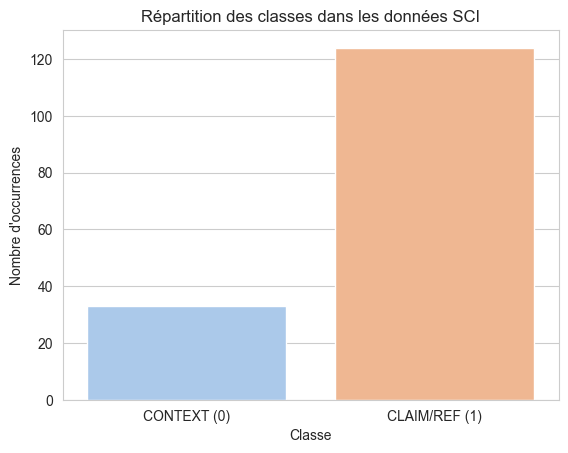

In [48]:
import seaborn as sb
import matplotlib.pyplot as plt

# 1. Afficher les occurrences par classe
print("Nombre d'occurrences par classe (0 = CONTEXT, 1 = CLAIM/REF) :\n")
print(df_sci['label'].value_counts())

# 2. Afficher la forme du dataset
print("\nShape:", df_sci.shape)

# 3. Fonction pour créer une distribution avec seaborn
def create_distribution(dataFile):
    sb.set_style("whitegrid")
    plot = sb.countplot(x='label', data=dataFile, palette='pastel')
    plot.set_xticklabels(['CONTEXT (0)', 'CLAIM/REF (1)'])
    plt.title("Répartition des classes dans les données SCI")
    plt.xlabel("Classe")
    plt.ylabel("Nombre d'occurrences")
    plt.show()

# 4. Appel de la fonction
create_distribution(df_sci)


In [55]:
# ➤ Classe CONTEXT uniquement (scientific_context == 1.0 et claim & ref == 0.0)
df_context = df_sci[
    (df_sci["scientific_context"] == 1.0) &
    (df_sci["scientific_claim"] == 0.0) &
    (df_sci["scientific_reference"] == 0.0)
]

# ➤ Classe CLAIM/REF (claim == 1.0 ou ref == 1.0), SANS context == 1.0
df_claim_ref = df_sci[
    ((df_sci["scientific_claim"] == 1.0) | (df_sci["scientific_reference"] == 1.0)) &
    (df_sci["scientific_context"] == 0.0)
]

# 4. Vérification du déséquilibre initial
print("Avant équilibrage :")
print("CLAIM/REF :", len(df_claim_ref))
print("CONTEXT   :", len(df_context))

# 5. Upsampling de CONTEXT vers la taille de CLAIM/REF
df_context_upsampled = resample(
    df_context,
    replace=True,
    n_samples=len(df_claim_ref),
    random_state=42
)

# 6. Fusion des deux sous-ensembles équilibrés
df_balanced = pd.concat([df_claim_ref, df_context_upsampled])

# 7. Vérification finale
print("\nAprès équilibrage :")
print("CLAIM/REF :", len(df_claim_ref))
print("CONTEXT (upsampled) :", len(df_context_upsampled))
print("Total lignes :", len(df_balanced))

Avant équilibrage :
CLAIM/REF : 124
CONTEXT   : 33

Après équilibrage :
CLAIM/REF : 124
CONTEXT (upsampled) : 124
Total lignes : 248


In [ ]:
#-------------------------------
#----Nettoyage + normalisation du texte--------
#------------------------------

In [40]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "URL", text)        # Remplace les liens par "URL"
    text = re.sub(r"@\w+", "MENTION", text)       # Remplace les mentions par "MENTION"
    text = re.sub(r"#(\w+)", r"\1", text)         # Supprime juste le #
    text = re.sub(r"[^\w\s]", "", text)           # Supprime la ponctuation
    text = re.sub(r"\s+", " ", text).strip()      # Supprime les espaces multiples
    return text
    
df_sci["clean_text"] = df_sci["text"].apply(clean_text)
df_sci["clean_text"]

2       can any gynecologist with cancer experience ex...
3       couchlock highs lead to sleeping in the couch ...
4       does daily routine help prevent problems with ...
7       can playing more games improve lives and save ...
14      MENTION MENTION MENTION pls support nih fundin...
                              ...                        
1109    MENTION my question is how many of these death...
1112    the covid19 pandemic is not over incorrect inf...
1130    this looks like a great opportunity to get res...
1131    highly prestigious and competitive awards fund...
1135    MENTION MENTION im sorry but we do not have 14...
Name: clean_text, Length: 157, dtype: object